##3.FEATURE ENGINEERING

####3.1 Correlation Analysis

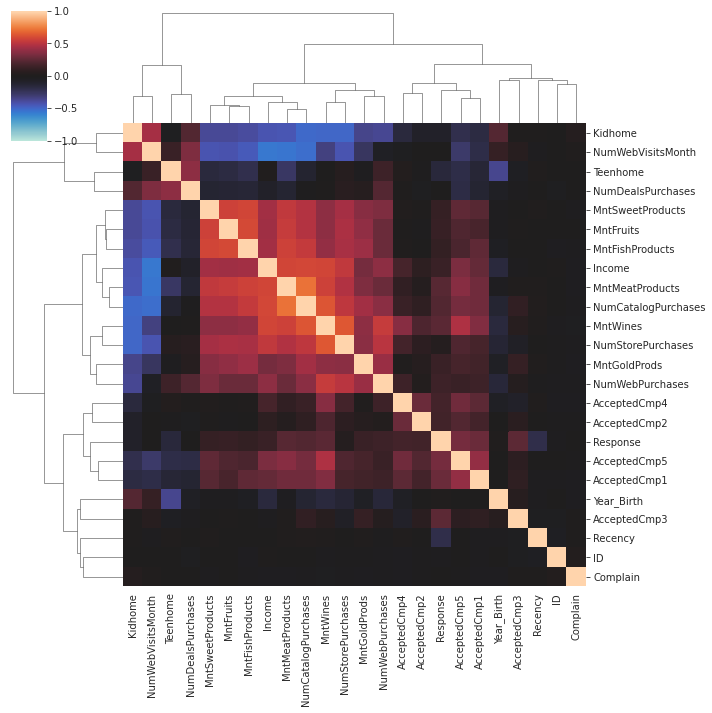

In [ ]:
sns.clustermap(
        df.corr(),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete"
    );

NOTE : No highly correlated variables with each other

### 3.2. Feature Encoding

In [ ]:
# to visualize categorical columns
def cat_val_graph(df, col_name):
  plt.figure(figsize = (8, 6))
  sns.countplot(x = df[col_name], palette = 'rocket_r')

##### Education

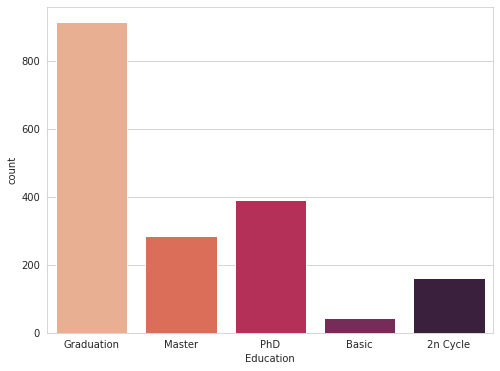

In [ ]:
cat_val_graph(X_train, 'Education')

In [ ]:
#Education levels are divided into three groups
X_train["Education"] = X_train["Education"].replace({'Basic':'Undergraduate', 
                                                     '2n Cycle':'Undergraduate', 
                                                     'Graduation':'Graduate', 
                                                     'Master' :'Postgraduate', 
                                                     'PhD' :'Postgraduate'})

X_test["Education"] = X_test["Education"].replace({'Basic':'Undergraduate', 
                                                   '2n Cycle':'Undergraduate', 
                                                   'Graduation':'Graduate', 
                                                   'Master' :'Postgraduate', 
                                                   'PhD' :'Postgraduate'})

In [ ]:
# new distribution
X_train["Education"].value_counts()

Graduate         913
Postgraduate     675
Undergraduate    203
Name: Education, dtype: int64

In [ ]:
# Does the test data contain data from all new categories? Checking before doing one-hot-encoding
X_test["Education"].value_counts()

Graduate         214
Postgraduate     180
Undergraduate     52
Name: Education, dtype: int64

In [ ]:
# to do one-hot-encoding
# don't forget, 'one-hot-encoding' automatically drop the original variable columns
X_train = pd.get_dummies(X_train, columns = ["Education"], prefix = ["Education"])
X_test = pd.get_dummies(X_test, columns = ["Education"], prefix = ["Education"])

#####'Marital Status'

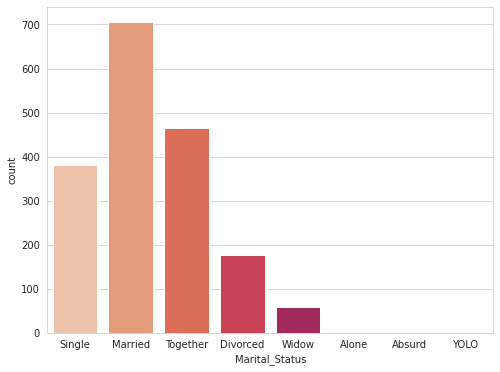

In [ ]:
cat_val_graph(X_train, 'Marital_Status')

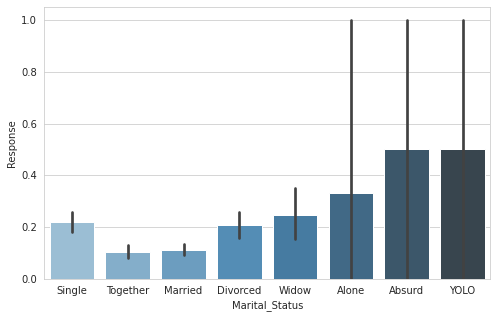

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=df['Marital_Status'], y=df['Response'], data=df,  palette="Blues_d");

In [ ]:
# There are too many category for 'Marital Status'
# Categories are divided into two groups representing married and single status
# Married and Together are represent by 1, Single, Divorced, Widow, Alone, Absurd and YOLO represent by 0
X_train['NewMaritalStatus'] = np.where((X_train['Marital_Status']=='Together')|(X_train['Marital_Status']=='Married'), 1, 0)
X_test['NewMaritalStatus'] = np.where((X_test['Marital_Status']=='Together')|(X_test['Marital_Status']=='Married'), 1, 0)

In [ ]:
# to check
X_train[['NewMaritalStatus','Marital_Status']].head()

,NewMaritalStatus,Marital_Status
792,0,Single
1271,0,Single
1538,1,Married
668,1,Married
1975,1,Married


#####Age

In [ ]:
X_train['Age'] = 2022 - X_train['Year_Birth']
X_test['Age'] = 2022 - X_test['Year_Birth']
X_train['Age'].head()

792     72
1271    59
1538    51
668     54
1975    53
Name: Age, dtype: int64

#####Dt_Customer variable convert to month scale

In [ ]:
# Dt_Customer
X_train['Dt_Customer'].head()

792     2013-07-19
1271    2013-01-22
1538    2012-10-16
668     2013-05-09
1975    2013-10-05
Name: Dt_Customer, dtype: object

In [ ]:
# creating Year, Month columns for further analysis

# convert the 'Date' column to datetime format
X_train['Dt_Customer']= pd.to_datetime(X_train['Dt_Customer'])
X_test['Dt_Customer']= pd.to_datetime(X_test['Dt_Customer'])

# to create Year and Month columns
X_train['Year'] = X_train["Dt_Customer"].dt.year
X_train['Month'] = X_train["Dt_Customer"].dt.month

X_test['Year'] = X_test["Dt_Customer"].dt.year
X_test['Month'] = X_test["Dt_Customer"].dt.month

In [ ]:
# to check
X_train[['Year', 'Month']].head()

,Year,Month
792,2013,7
1271,2013,1
1538,2012,10
668,2013,5
1975,2013,10


In [ ]:
# to drop all unnecessary columns
drop_columns = ['Marital_Status','Year_Birth','Dt_Customer']
X_train.drop(drop_columns, axis=1, inplace=True)
X_test.drop(drop_columns, axis=1, inplace=True)

### 3.3. Feature Selection

####Feature Importance

In [ ]:
print(X_train['ID'].nunique())
print(X_test['ID'].nunique())

1791
446


In [ ]:
# Every ID represents just one row so no need grouping these
X_train.drop('ID', inplace=True, axis=1)
X_test.drop('ID', inplace=True, axis=1)

In [ ]:
y_train = X_train[['Response']]
X_train = X_train.drop('Response', axis = 1)
y_test = X_test[['Response']]
X_test = X_test.drop('Response', axis = 1)

In [ ]:
# We'll train a model to identify the importance of features
rf_model = RandomForestClassifier().fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)

<ipython-input-75-8f309a757628>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = RandomForestClassifier().fit(X_train,y_train)


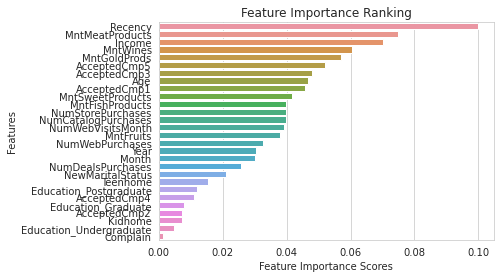

In [ ]:
feature_importance = pd.Series(rf_model.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Scores')
plt.ylabel('Features')
plt.title("Feature Importance Ranking")
plt.show()

NOTES :

By selecting features, we want to create a model that is more generalizable, has a shorter training time, and can predict with higher accuracy.

[1] 'Complain' column is least important columns, so We'll to drop it.

[2] We will try to create more effective columns than those with less important column.

###3.4.Feature Creation and Aggregation

In [ ]:
X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)

In [ ]:
# Collecting all expenses column together
X_train['TotalMntSpent'] = sum((X_train['MntWines'], X_train['MntFruits'],
                               X_train['MntMeatProducts'], X_train['MntFishProducts'], 
                               X_train['MntSweetProducts'], X_train['MntGoldProds'])) 

X_test['TotalMntSpent'] = sum((X_test['MntWines'], X_test['MntFruits'],
                               X_test['MntMeatProducts'], X_test['MntFishProducts'], 
                               X_test['MntSweetProducts'], X_test['MntGoldProds']))

In [ ]:
# to create a new column with the total family member size
X_train['FamilySize'] = X_train['Teenhome'] + X_train['Kidhome'] + X_train['NewMaritalStatus'] + 1

X_test['FamilySize'] = X_test['Teenhome'] + X_test['Kidhome'] + X_test['NewMaritalStatus'] + 1

In [ ]:
X_train[['Teenhome','Kidhome','NewMaritalStatus','Response']].corr()

,Teenhome,Kidhome,NewMaritalStatus,Response
Teenhome,1.00,-0.05,0.02,-0.16
Kidhome,-0.05,1.00,0.03,-0.10
NewMaritalStatus,0.02,0.03,1.00,-0.15
Response,-0.16,-0.10,-0.15,1.00


In [ ]:
X_train[['FamilySize', 'Response']].corr()

,FamilySize,Response
FamilySize,1.00,-0.23
Response,-0.23,1.00


In [ ]:
# to drop all unnecessary columns
# 'Complain' variable has very little importance according to feature importance analysis so this variable has been dropped
drop_columns=['Complain','MntWines', 'MntFruits', 
              'MntMeatProducts', 'MntFishProducts', 
              'MntSweetProducts', 'MntGoldProds', 
              'Kidhome','Teenhome','NewMaritalStatus'
          ]

X_train.drop(drop_columns, inplace=True, axis=1)
X_test.drop(drop_columns, inplace=True, axis=1)